# Predicción de Series de Tiempo con Redes LSTM

Las tareas de predicción son un tópico frecuente en los desarrollos de Machine Learning actuales. Las unidades LSTM son un modelo de red neuronal recurrente, cuya principal promesa es aprender de secuencias largas de observaciones. Con esta premisa en mente, es natural pensar en lo propicio que puede llegar a ser el empleo de LSTM con series de tiempo.
En este tutorial vamos a aprender como desarrollar un modelo de LSTM para predecir una serie de tiempo en un solo paso. La estructura del tutorial será la siguiente:

- Conjunto de datos del dsempleo EE.UU
- Preparación de los retardos
- División del conjunto en entrenamiento y prueba
- Normalización de los conjuntos de datos
- Definición y entrenamiento del modelo LSTM
- Predicción usando datos de prueba

En la primera celda tenemos una lista con las librerias necesarias para llevar a cabo el tutorial, además de la definición de cuatro funciones que necesitamos y explicaremos más adelante.

In [10]:
import pandas as pd
import numpy as np
from math import sqrt

import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_pacf

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, LSTM

def make_lags(ts, lags):
    return pd.concat(
        {
            f'y_lag_{i}': ts.shift(i)
            for i in range(1, lags + 1)
        },
        axis=1)

def scale(train, test, r_min=0, r_max=1):
    # fit scaler
    scaler = MinMaxScaler(feature_range=(r_min, r_max))
    scaler = scaler.fit(train)
    # transform train
    train = train.reshape(train.shape[0], train.shape[1])
    train_scaled = scaler.transform(train)
    # transform test
    test = test.reshape(test.shape[0], test.shape[1])
    test_scaled = scaler.transform(test)
    return scaler, train_scaled, test_scaled

# inverse scaling for a forecasted value
def invert_scale(scaler, X, value):
    new_row = [x for x in X] + [value]
    array = np.array(new_row)
    array = array.reshape(1, len(array))
    inverted = scaler.inverse_transform(array)
    return inverted[0, -1]

# make a one-step forecast
def forecast_lstm(model, batch_size, X):
    X = X.reshape(1, 1, len(X))
    yhat = model.predict(X, batch_size=batch_size)
    return yhat[0,0]

### Conjunto de Datos
El conjunto de datos de la Reserva Federal nos brinda datos de algunas variables económicas en EE.UU. desde 1954 hasta 2017 con mediciones mensuales. Los datos de año, mes y día vienen como características separadas, por lo cual vamos a generar una sola característica con estos datos y además quedarán establecidos como el índice de la matriz. Específicamente, nos interesa la tasa de desempleo, por lo cual limpiamos otros datos irrelevantes para nuestro ejercicio, adicionalmente determinamos el periodo de mediciones mensual, como habíamos mencionado anteriormente.

In [11]:
data = pd.read_csv(
    "desempleo.csv",
    parse_dates={'Date': ['Year', 'Month', 'Day']},
    index_col='Date',
)
y = data.loc[:, 'Unemployment Rate'].dropna().to_period('M')

y.head()

Date
1954-07    5.8
1954-08    6.0
1954-09    6.1
1954-10    5.7
1954-11    5.3
Freq: M, Name: Unemployment Rate, dtype: float64

Si observamos la gráfica de la serie de tiempo, podemos hablar de que la serie no es estacional, ni tampoco presenta una tendencia. Así, el siguiente paso es verificar si se puede modelar la serie mediante retardos.

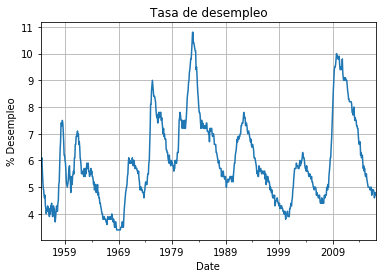

In [12]:
ax = y.plot(title='Tasa de desempleo')
_ = ax.set(ylabel="% Desempleo")
ax.grid(True)

### Preparación de los Retardos

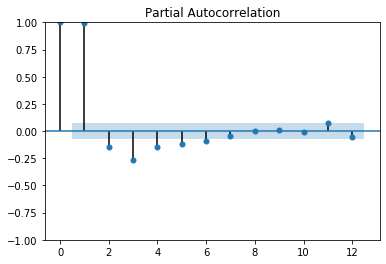

In [13]:
_ = plot_pacf(y, lags=12, method='ywm')

Al graficar la autocorrelación parcial podemos observar que hasta el retardo 4 o 5 se aporta información importante para el problema. Para este tutorial vamos a generar hasta 4 retrasos, para esto hacemos uso de la función make_lags, la cual recibe como parámetros el conjunto de datos a tratar y el número de retardos a generar. Esta función hace la cantidad de retardos requerida mediante el uso de la función shift() de Pandas.

Al generar los retardos, se crean nuevas posiciones en la serie que contiene valores NaN (Not a Number), estos son reemplazados con 0. Los valores establecidos en 0 deben ser interpretados por el modelo LSTM como el “inicio de la serie” o con “No hay datos para este periodo”.

In [14]:
#Generamos los lags
X = make_lags(y, lags=4)
X = X.fillna(0.0)

### División del Conjunto en Entrenamiento y Prueba
En una primera aproximación se podría pensar en evaluar un modelo con los datos usados para entrenar. Pero esto no sería valido, pues no se obtendría una idea de cómo funciona el modelo ante nuevos datos. Esta evaluación podría proporcionar una visión de cómo funciona el modelo, e incluso de cómo podría ser mejorado. Sin embargo, cualquier estimación realizada utilizando estos datos es optimista. Además, cualquier decisión basada en esta actuación estaría sesgada.

Cuando se evalúa un modelo para predicción de series de tiempo, estamos interesados en el rendimiento del modelo con datos que no fueron usados para el entrenamiento. En Machine Learning se llaman estos datos no vistos o fuera de muestra.
Podemos evaluar los modelos dividiendo los datos disponibles. Usamos algunos datos para preparar el modelo, pero mantenemos algunos datos para que el modelo entrenado haga predicciones en ese periodo. La evaluación de estas predicciones proporcionará una buena aproximación a cómo se comportará el modelo cuando lo utilicemos operativamente.

Normalmente, la división en los conjuntos de entrenamiento y prueba se ejecuta de manera aleatoria. Esto se realiza porque se asume que cada observación es independiente de las otras. Sin embargo, esta idea no se aplica para series de tiempo, donde la dimensión del tiempo implica que no se pueden dividir aleatoriamente los datos. En cambio, se deben dividir respetando el orden temporal en el cual se realizaron las observaciones.

Usar el método de división de entrenamiento-prueba para evaluar modelos de Machine Learning es rápido, la preparación de datos es intuitiva y solo un modelo es creado y evaluado. Este método es útil cuando se tienen conjuntos de datos grandes, de tal forma que tanto el conjunto de entrenamiento, como el conjunto de prueba, sean representativos para el problema original.

En este caso, realizamos tomamos los últimos 120 meses (10 años) observados como datos de prueba. Para la división del conjunto utilizamos la función train_test_split de Scikit-Learn, teniendo en cuenta que se debe configurar el parámetro shuffle como False. Un paso adicional es tomar en cuenta el indice de tiempo de los datos de entrenamiento y prueba.

In [15]:
#dividimos los datos en entrenamiento y prueba
Xtrain, Xtest, ytrain, ytest = train_test_split(X, y, test_size=120, shuffle=False)

train_index = ytrain.index
test_index = ytest.index

### Normalización del Conjunto de Datos
Algunos modelos de Machine Learning pueden ver afectado su rendimiento ante datos con escalas o distribuciones no consistentes. Esta situación se presenta frecuentemente con datos tomados en la realidad; donde una característica puede estar en un rango de [0,1], mientras que otra esta entre [0,100]. Esta última característica puede resultar más influyente en los resultados alcanzados debido a su magnitud, aun cuando no necesariamente sea la característica más relevante para el predictor.

La normalización es un proceso de ajuste de escalas de los valores medidos originalmente de tal manera que todos los datos estén dentro de un rango establecido, normalmente para Machine Learning [0,1], [-1,1], dependiendo de las funciones de activación utilizadas.

La normalización puede ser útil, e incluso requerida para algunos algoritmos de Machine Learning cuando tu serie de tiempo tiene datos de entrada con diferentes escalas. Este proceso puede ser requerido para algoritmos como k-Vecinos Cercanos, la cual usa cálculos de distancia, regresión Lineal y Redes Neuronales Artificiales que ponderan los valores de entrada.
Para el proceso de normalización se requiere tener el conocimiento del máximo y el mínimo de los datos observados. Este rango puede ser obtenido directamente de las observaciones disponibles. Sin embargo, si la serie de tiempo tiene tendencias ascendentes o descendentes, estimar los valores esperados puede no ser conveniente y la normalización puede no ser el mejor método para usar en el problema.

Un registro es normalizado como: $ y = (x-min)/(max-min)$. La normalización se puede realizar usando el objeto MinMaxScaler de scikit-learn. Algunos tips de buenas prácticas de uso para la normalización son:
1.	Identificar el mínimo y máximo de los valores observables utilizando los datos de entrenamiento.
2.	Aplicar la normalización a los datos de entrenamiento.
3.	Aplicar el factor de escalado a los datos nuevos. Esto significa preparar nuevos datos en el futuro sobre los que quieres hacer predicciones.

La normalización también puede ser invertida. Esto es útil para convertir las predicciones de regreso a la escala original y realizar facilmente las comparaciones necesarias o para fines de visualización.


In [16]:
y_train = ytrain.values.reshape(-1,1)
y_test = ytest.values.reshape(-1,1)

tr = np.concatenate((Xtrain, y_train), axis=1)
test = np.concatenate((Xtest, y_test), axis=1)

#aplicar el escalado
scaler, tr, test = scale(tr, test, -1, 1)

X_train = tr[:,0:-1]
y_train = tr[:,-1].reshape(-1,1)

X_test = test[:,0:-1]
y_test = test[:,-1].reshape(-1,1)

### Definición y Entrenamieno LSTM
Las LSTM son un modelo de red neuronal recurrente, que tiene la capacidad de aprender largas secuencias de observaciones. Puede ser una herramienta útil para realizar predicciones de series de tiempo.

Una de las ventajas de los modelos LSTM es que no depende de una observación con una ventana de retardo preestablecida como entrada. En keras, esta característica se conoce como “stateful”, que debe activarse como argumento “True” cuando se define una capa LSTM.

Por defecto, en keras una capa LSTM mantiene el estado entre los datos en un batch. Un batch de datos es un número fijo de filas del conjunto de datos que define cuantos ejemplos son procesados antes de actualizar los pesos de la red. Los estados en una capa LSTM son limpiados entre batches por defecto, sin embargo, debemos hacer la LSTM “stateful”. Esta propiedad nos brinda la opción de tener control granular sobre cuando el estado de una LSTM es limpiado, llamando la función reset_states().

La capa LSTM espera tener como entrada una matriz con dimensiones: [muestras, pasos de tiempo, características]. 
- Muestras: Son observaciones independientes del problema. Típicamente corresponden a las filas de los datos.
- Pasos de tiempo: Son pasos de tiempo separados de una variable dada para una observación determinada.
- Características: Son las mediciones observadas en cada tiempo de observación.


In [17]:
#Ajustamos las dimensiones de la matriz de entrenamiento
#Numero de ejemplos, batch size, caracteristicas
X_train = X_train.reshape(X_train.shape[0], 1, X_train.shape[1])

El tamaño del batch es normalmente mucho más pequeño que el número total de ejemplos. El número de épocas y el tamaño del batch definen que tan rápido la red aprende de los datos (que tan frecuentemente los pesos son actualizados).

Un parámetro importante a definir es el número de neuronas, también llamado número de unidades de memoria o bloques. Dependiendo de la complejidad del problema se elegirá el número de unidades. Este parámetro debe ser explorado con base en diversas pruebas del rendimiento de la red. Para tener puntos de referencia estándar se elige tomar como medida del error la Raíz del Error Cuadrático Medio. El RMSE nos permite tener una medida de la diferencia entre las predicciones y la serie original en la misma magnitud que los datos de entrada.

Cuando compilamos el modelo de red neuronal a utilizar, definimos como función de pérdida o de minimización el Mean Squared Error (Error Cuadrático Medio) y posteriormente extraemos la raíz cuadrada para obtener el RMSE.

In [18]:
EPOCHS = 50
batch_size = 1

in_dim = (batch_size, X_train.shape[1], X_train.shape[2])
out_dim = y_train.shape[1]

Para definir una red neuronal LSTM en Keras vamos a utilizar el método secuencial, el cual indica que las capas de la red neuronal se agregarán una tras otra en el orden que establezcamos. Usando el método add empezamos a agregar las capas de forma ordenada.
- La primera capa que utilizaremos es la LSTM, configurada con 16 unidades de memoria y función de activación ReLU. Por ser la capa de entrada del modelo, debemos indicar las dimensiones de los datos de entrada.
- La segunda y cuarta capa utilizada es la de Dropout, básicamente esta capa elimina conexiones sinápticas entre capa con una probabilidad. Esta función es útil para reducir efectos de sobre ajuste a los datos.
- La tercera capa, es una capa totalmente conectada, básicamente se configura el número de neuronas a entrenar. Si la función de activación no se especifica, se aplica la salida lineal, es decir, $ a(x) = x $.
- La última capa utilizada es la de salida, donde el número de unidades de salida depende del número de columnas del objetivo. En este caso 1.

In [19]:
model = Sequential()
model.add(LSTM(units = 16, batch_input_shape=(in_dim),
               stateful = True, activation="relu"))
model.add(Dropout(0.2))
model.add(Dense(5))
model.add(Dropout(0.2))
model.add(Dense(1))

model.compile(loss="mse", optimizer="adam", metrics=["accuracy"])

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (1, 16)                   1344      
_________________________________________________________________
dropout (Dropout)            (1, 16)                   0         
_________________________________________________________________
dense (Dense)                (1, 5)                    85        
_________________________________________________________________
dropout_1 (Dropout)          (1, 5)                    0         
_________________________________________________________________
dense_1 (Dense)              (1, 1)                    6         
Total params: 1,435
Trainable params: 1,435
Non-trainable params: 0
_________________________________________________________________


En el proceso de entrenamiento de un modelo de Machine Learning, por defecto los ejemplos dentro de cada época son mezclados. Este es un comportamiento que no deseamos tener en el entrenamiento de nuestra LSTM, pues esperamos que la red aprenda a través de la secuencia de observaciones. Podemos deshabilitar esta propiedad estableciendo el parámetro shuffle = False.

In [20]:
for i in range(EPOCHS):
    H = model.fit(X_train, y_train, epochs=1, batch_size=batch_size,
                  verbose=0, shuffle=False)
    model.reset_states()

Una vez el modelo está ajustado a los datos de entrenamiento, este puede ser usado para hacer predicciones.

Tenemos dos enfoques para realizar las predicciones, en el primero de ellos se ajusta el modelo con los datos de entrenamiento y se realizan predicciones una por una a partir de los datos de prueba. Por otra parte, podemos ajustar el modelo cada vez que se tengan disponibles nuevas observaciones de los datos de prueba. En este tutorial seguiremos el primer enfoque mencionado.

Durante el entrenamiento, el estado interno es reiniciado después de cada época. Mientras que, para la predicción no deseamos reiniciar el estado interno entre predicciones. De hecho, nos gustaría que el modelo construyera el estado a medida que pronosticamos cada paso de tiempo en el conjunto de datos de prueba.

Esto genera la pregunta, ¿Cuál debería ser el estado inicial de la red previo a predecir los datos de prueba? Para este tutorial, inicializaremos los estados de la red haciendo predicciones sobre el conjunto de datos de entrenamiento. En teoría, el estado del modelo quedaría ajustado para realizar las predicciones del siguiente paso de tiempo.


In [21]:
y_pred = model.predict(X_train, batch_size=batch_size)
data = np.concatenate((X_train[:,0,:], y_pred), axis=1)
y_pred = scaler.inverse_transform(data)
y_pred = pd.Series(y_pred[:,0], index=train_index)

# walk-forward validation on the test data
predictions = list()
for i in range(len(X_test)):
    # make one-step forecast
    yhat = forecast_lstm(model, 1, X_test[i,:])
    # invert scaling
    yhat = invert_scale(scaler, X_test[i,:], yhat)
    # store forecast
    predictions.append(yhat)
    
y_fore = pd.DataFrame(predictions, index=test_index)
    
rmse = sqrt(mean_squared_error(ytest,y_fore))
print('RMSE = ', rmse)

RMSE =  0.6037082632766033


Como podemos observar la red neuronal ajusta los datos de entrenamiento y prueba adecuadamente. Si verificamos el RMSE con los datos de prueba tenemos un error promedio menor al 1%. Es importante destacar que tras cada ejecución del algoritmo se obtendrán diferentes resultados, pues hay un proceso estocástico en la inicialización de los pesos de la red.

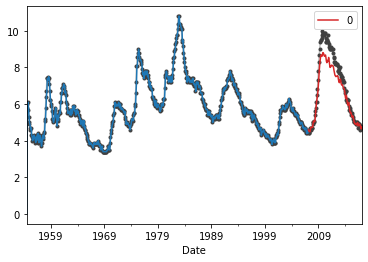

In [22]:
y_train = pd.DataFrame(y_train)
ax = ytrain.plot(color="0.75", style=".-", markeredgecolor="0.25", markerfacecolor="0.25")
ax = ytest.plot(ax=ax,color="0.75", style=".-", markeredgecolor="0.25", markerfacecolor="0.25")
ax = y_pred.plot(ax=ax)
_ = y_fore.plot(ax=ax, color='C3')
plt.show()

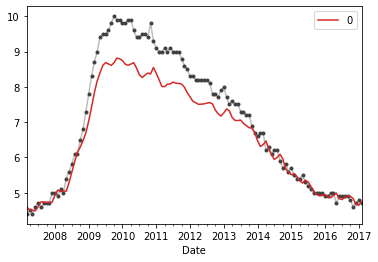

In [23]:
ax = ytest.plot(color="0.75", style=".-", markeredgecolor="0.25",
                markerfacecolor="0.25", label="Test data")
_ = y_fore.plot(ax=ax, color='C3', label="Test pred")
plt.show()

Como se mencionó anteriormente de forma breve, en el proceso de entrenamiento e inicialización de pesos de la red neuronal se presenta un proceso estocástico. Este proceso genera que tras cada ejecución del algoritmo se alcancen resultados diferentes en la clasificación, predicción, etc. Teniendo en cuenta este fenómeno, es importante realizar varios entrenamientos de la red neuronal antes de sacar conclusiones del rendimiento del modelo. Es recomendable que al momento de realizar análisis de los modelos, estos se hagan con base en el promedio de los rendimientos obtenidos en los entrenamientos.

## Conclusiones
En este tutorial aprendimos como utilizar la librería Keras para definir, entrenar y predecir valores futuros de una serie de tiempo, utilizando un modelo recurrente sencillo con LSTM. Ahora sabemos cómo hacer una breve preparación a los datos para obtener rendimientos aceptables en nuestros modelos de Machine Learning, específicamente, el proceso de generación de retardos, división del conjunto de datos y normalización de los ejemplos. También entendemos que al ser un proceso estocástico la inicialización y entrenamiento de la red neuronal, se debe ejecutar más de un entrenamiento para tener una idea más acertada del rendimiento esperado de la red.